In [1]:
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import early_stopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.metrics import r2_score

# Data Preprocess

In [2]:
# Read the dataset containing income and population data
rent_data = pd.read_csv('../data/curated/rent.csv')

# Formula: Growth Rate = (Current Year - Previous Year) / Previous Year
# Calculate Income Growth Rate
for year in range(2001, 2028): # Calculate from 2001 to 2027
    rent_data[f'income_growth_{year}'] = (rent_data[f'{year}_x'] - rent_data[f'{year-1}_x']) / rent_data[f'{year-1}_x']

# Calculate Population Growth Rate
for year in range(2001, 2028): # Calculate from 2001 to 2027
    rent_data[f'population_growth_{year}'] = (rent_data[f'{year}_y'] - rent_data[f'{year-1}_y']) / rent_data[f'{year-1}_y']

# Read the property data
property_data = pd.read_csv('../data/landing/property_with_nearest_distance.csv')

# Extract the postcode from the 'name' column and ensure its type is a string
property_data['postcode'] = property_data['name'].str.extract(r'VIC (\d{4})')
property_data['postcode'] = property_data['postcode'].astype(str)

# Ensure that the postcode in the rent data is also a string
rent_data['postcode'] = rent_data['postcode'].astype(str)

# Merge the property data with rent data based on the postcode
model_data = pd.merge(property_data, rent_data, on='postcode', how='left')

# Check
model_data.head(10)

,name,Bed_x,weekly_rent,latitude,longitude,geometry,nearest_tram_stop,nearest_tram_stop_distance_km,nearest_train_stop,nearest_train_stop_distance_km,...,population_growth_2018,population_growth_2019,population_growth_2020,population_growth_2021,population_growth_2022,population_growth_2023,population_growth_2024,population_growth_2025,population_growth_2026,population_growth_2027
0,"1208/50 Albert Street, South Melbourne VIC 3205",1,520.0,-37.834344,144.955904,POINT (2496118.3794249045 2407409.7981049973),127-South Melbourne Station/Light Rail (South ...,0.136816,67-Camberwell Girls Grammar/Burke Rd (Hawthorn...,1.863573,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"64 Mills Street, Albert Park VIC 3206",3,1495.0,-37.846426,144.958009,POINT (2496304.26476775 2406068.9190204293),135-Richardson St/Mills St (Middle Park),0.090635,49-Buchanan Ave/Doncaster Rd (Balwyn North),2.824165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.092556,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635
3,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.092556,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635
4,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.092556,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635
5,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.092556,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635
6,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.092556,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635
7,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.092556,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635
8,"1104/70 Southbank Boulevard, Southbank VIC 3006",1,420.0,-37.823158,144.963953,POINT (2496826.48889558 2408651.6629420286),115-Casino/Southbank/Queens Bridge St (Southbank),0.266535,41-Cantala Ave/Dandenong Rd (Armadale),0.600295,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"167 Charman Road, Beaumaris VIC 3193",4,950.0,-37.974606,145.053631,POINT (2504712.147891326 2391841.451691285),68-East Brighton/Hawthorn Rd (Brighton East),7.439762,68-Mont Albert Rd/Burke Rd (Camberwell),0.886863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Handle missing values, you can choose to fill with mean, median, etc.
model_data.fillna(0, inplace=True)

# Select the features for the model and the target variable
# X represents all the features, y represents the rental price (target)
X = model_data[['nearest_tram_stop_distance_km', 'nearest_train_stop_distance_km', 
                'nearest_school_distance_km', 'income_growth_2025', 'income_growth_2026', 'income_growth_2027',
                'population_growth_2025', 'population_growth_2026', 'population_growth_2027',
                'tram_count', 'school_total', 'park_count']]
y = model_data['weekly_rent']  # Rental price

# Split the data into training and testing sets, with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training LightGBM Model

In [4]:
# Create LightGBM datasets for training and validation
train_data_lgb = lgb.Dataset(X_train, label=y_train)
valid_data_lgb = lgb.Dataset(X_test, label=y_test, reference=train_data_lgb)

# Set LightGBM parameters
params = {
    'objective': 'regression',  # Regression task
    'metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Trees
    'learning_rate': 0.05,  # Learning rate
    'num_leaves': 31,  # Number of leaves
    'max_depth': -1,  # No limit on tree depth
    'verbose': 0  # No verbose output
}

# Train the model with early stopping
model = lgb.train(
    params,
    train_data_lgb,
    valid_sets=[train_data_lgb, valid_data_lgb],  # Use both training and validation datasets
    valid_names=['train', 'valid'],  # Assign names to the datasets for clarity
    num_boost_round=500,  # Number of boosting rounds
    callbacks=[early_stopping(stopping_rounds=50)]  # Use early stopping with 50 rounds patience
)

# Predict using the trained model
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model's performance using the new root_mean_squared_error function
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	train's rmse: 39.9023	valid's rmse: 44.8028
RMSE: 44.802849250639525


In [5]:
# When R² is close to 1, the model performs well.
r2 = r2_score(y_test, y_pred)
print(f'R² score: {r2}') 

R² score: 0.9999105590025804


# Prediction of rental prices for the next three years

In [6]:
# Generate future dataset features, including population and income growth for the next three years
future_data = model_data[['nearest_tram_stop_distance_km', 'nearest_train_stop_distance_km', 
                'nearest_school_distance_km', 'income_growth_2025', 'income_growth_2026', 'income_growth_2027',
                'population_growth_2025', 'population_growth_2026', 'population_growth_2027',
                'tram_count', 'school_total', 'park_count']]  # Update with the features relevant to future data

# Use the trained model to make predictions on the future data
future_predictions = model.predict(future_data)

# Add the predicted rent values to the original dataset
model_data['predicted_rent'] = future_predictions

# Check
model_data.head(10)

,name,Bed_x,weekly_rent,latitude,longitude,geometry,nearest_tram_stop,nearest_tram_stop_distance_km,nearest_train_stop,nearest_train_stop_distance_km,...,population_growth_2019,population_growth_2020,population_growth_2021,population_growth_2022,population_growth_2023,population_growth_2024,population_growth_2025,population_growth_2026,population_growth_2027,predicted_rent
0,"1208/50 Albert Street, South Melbourne VIC 3205",1,520.0,-37.834344,144.955904,POINT (2496118.3794249045 2407409.7981049973),127-South Melbourne Station/Light Rail (South ...,0.136816,67-Camberwell Girls Grammar/Burke Rd (Hawthorn...,1.863573,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,629.252848
1,"64 Mills Street, Albert Park VIC 3206",3,1495.0,-37.846426,144.958009,POINT (2496304.26476775 2406068.9190204293),135-Richardson St/Mills St (Middle Park),0.090635,49-Buchanan Ave/Doncaster Rd (Balwyn North),2.824165,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,939.230444
2,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635,442.908041
3,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635,442.908041
4,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635,442.908041
5,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635,442.908041
6,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635,442.908041
7,"11 Barnato St, Weir Views VIC 3338",4,460.0,-37.718775,144.554187,POINT (2460697.114285021 2420145.1730066407),49-Central Park Ave/Cordite Ave (Maribyrnong),29.072242,46-Orrong Rd/Glenhuntly Rd (Elsternwick),17.817118,...,0.107114,0.118109,0.090345,0.086704,0.08117,-0.118531,0.058651,0.058645,0.058635,442.908041
8,"1104/70 Southbank Boulevard, Southbank VIC 3006",1,420.0,-37.823158,144.963953,POINT (2496826.48889558 2408651.6629420286),115-Casino/Southbank/Queens Bridge St (Southbank),0.266535,41-Cantala Ave/Dandenong Rd (Armadale),0.600295,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,657.538056
9,"167 Charman Road, Beaumaris VIC 3193",4,950.0,-37.974606,145.053631,POINT (2504712.147891326 2391841.451691285),68-East Brighton/Hawthorn Rd (Brighton East),7.439762,68-Mont Albert Rd/Burke Rd (Camberwell),0.886863,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,588.989264


In [12]:
# Save
model_data.to_csv('../data/curated/predicted_rent_prices.csv', index=False)

# Visualization

In [7]:
import matplotlib.pyplot as plt
import lightgbm as lgb

from lightgbm import early_stopping, record_evaluation

### Feature Importance

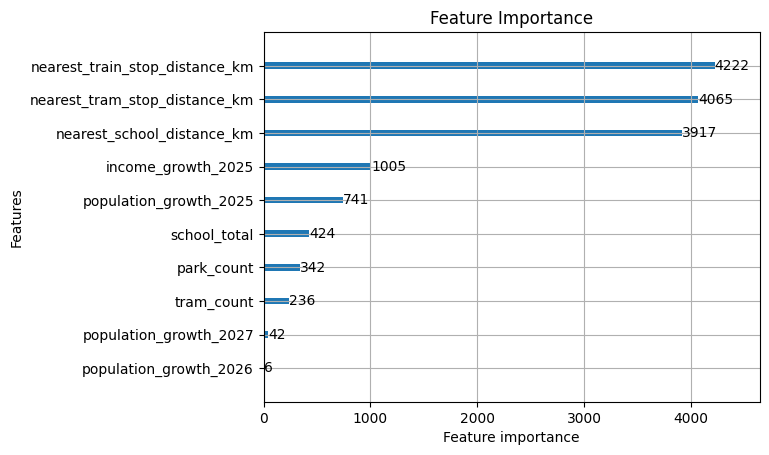

In [8]:
# Visualize feature importance
lgb.plot_importance(model, max_num_features=10)  # Display only the top 10 most important features
plt.title("Feature Importance")
plt.show()

### Training Process Visualization

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	train's rmse: 39.9023	valid's rmse: 44.8028


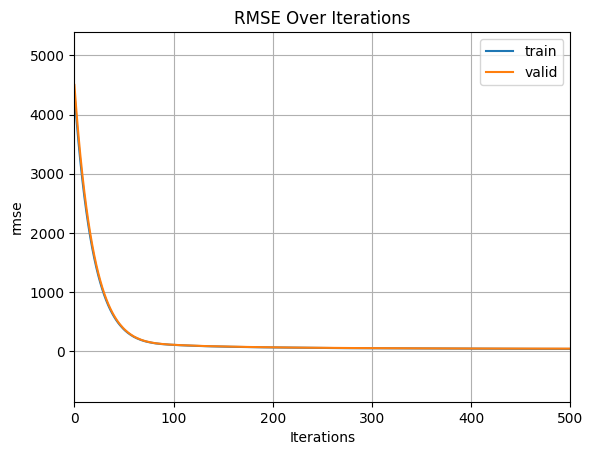

In [9]:
# Check the convergence of the model.
# Introduce the callback function to record evaluation results
eval_results = {}

# Use early stopping and evaluation result recording callbacks
callbacks = [
    early_stopping(stopping_rounds=50),  # Stop if no improvement after 50 rounds
    record_evaluation(eval_results)  # Record evaluation results during training
]

# Train the model
model = lgb.train(
    params,
    train_data_lgb,
    valid_sets=[train_data_lgb, valid_data_lgb],  # Use both training and validation datasets
    valid_names=['train', 'valid'],  # Name the datasets for better output understanding
    num_boost_round=500,  # Number of boosting iterations
    callbacks=callbacks  # Use callbacks to implement early stopping and record evaluation results
)

# Plot the RMSE over iterations on the validation dataset
lgb.plot_metric(eval_results, metric='rmse')
plt.title("RMSE Over Iterations")
plt.show()

### Prediction vs Actual

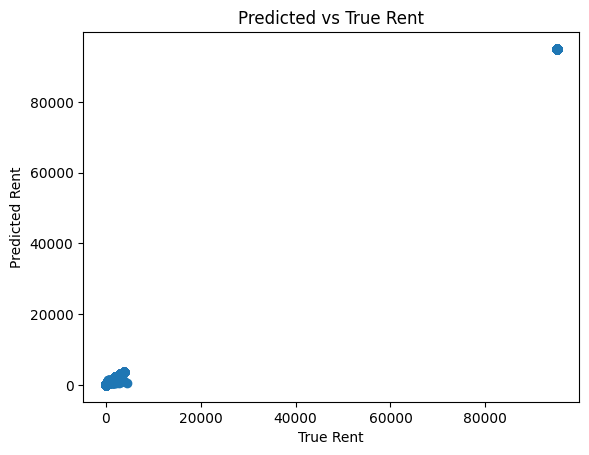

In [10]:
# Visualize the predicted vs. actual rent values
plt.scatter(y_test, y_pred)
plt.xlabel("True Rent")
plt.ylabel("Predicted Rent")
plt.title("Predicted vs True Rent")
plt.show()

### Residual Plot

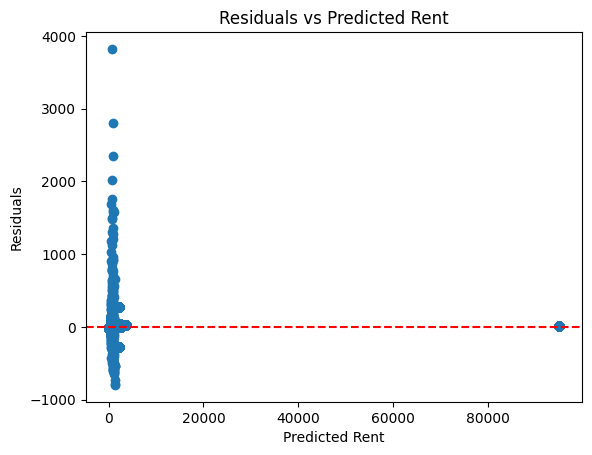

In [11]:
# Check the quality of the model fit.
# Calculate the residuals (difference between the actual and predicted values)
residuals = y_test - y_pred

# Visualize the residuals
plt.scatter(y_pred, residuals)  # Scatter plot of predicted rent vs residuals
plt.xlabel("Predicted Rent")  # Label for the x-axis
plt.ylabel("Residuals")  # Label for the y-axis
plt.title("Residuals vs Predicted Rent")  # Title of the plot
plt.axhline(0, color='red', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.show()  # Display the plot